This jupyter notebook will load the data for studying reclying and waste in NYC city. We wil clean and collate data of three kinds: (1) recyling and waste generation rates per community district in NYC, (2) population and demographics of NYC and (3) infrastucutre of NYC--namely builiding type etc per CDTA

All data files neeeded to do the analysis is in the file named "datas" in the parent folder. 

Before opeing the data files, we will load all the packages.

In all codes we will use the following colors for the boroughs and the total value 
borough_colors = {
    'MN': '#6D9EC1',  # Darker pastel blue for Manhattan
    'BK': '#7CB342',  # Darker pastel green for Brooklyn
    'BX': '#E57373',  # Darker pastel red for Bronx
    'Q': '#FFB74D',   # Darker pastel orange for Queens
    'SI': '#9575CD',  # Darker pastel purple for Staten Island
    'Total': '#5D5D5D}
and we will use "coolwarm" whenever we are using gradients.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import geopandas as gpd
from matplotlib.patches import Patch
import camelot

Dataset #1: The community district in NYC. 

Before analyzing the data, run this code to get familiar with the city's geography, burroughs and community districts, hereon labelled as CDTA.

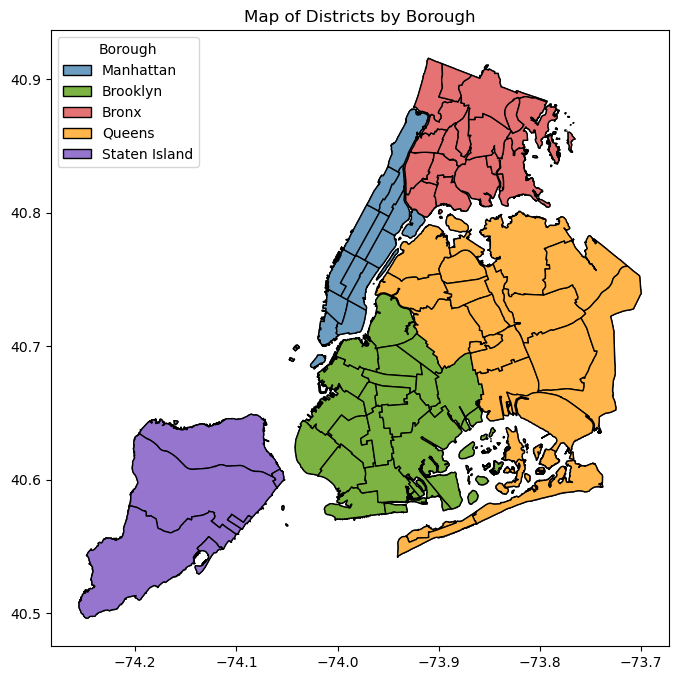

In [36]:
gdf = gpd.read_file("datas/NYC_Community_District_Tabulation_Areas_2020_769164889669816788.geojson")

# Define borough colors
borough_colors = {
    'MN': '#6D9EC1',  # Darker pastel blue for Manhattan
    'BK': '#7CB342',  # Darker pastel green for Brooklyn
    'BX': '#E57373',  # Darker pastel red for Bronx
    'Q': '#FFB74D',   # Darker pastel orange for Queens
    'SI': '#9575CD',  # Darker pastel purple for Staten Island
}

# Map full borough names to abbreviations
borough_map = {
    'Manhattan': 'MN',
    'Brooklyn': 'BK',
    'Bronx': 'BX',
    'Queens': 'Q',
    'Staten Island': 'SI'
}

# Add borough code column
gdf['BoroCode'] = gdf['BoroName'].map(borough_map)

# Add color column based on borough code
gdf['color'] = gdf['BoroCode'].map(borough_colors)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with direct color specification
gdf.plot(
    ax=ax,
    color=gdf['color'],
    edgecolor="black"
)

# Create custom legend elements
legend_elements = [
    Patch(facecolor=borough_colors[code], edgecolor='black', label=name)
    for name, code in borough_map.items()
]

# Add the legend
ax.legend(
    handles=legend_elements,
    loc='upper left',
    frameon=True,
    title="Borough"
)

plt.title("Map of Districts by Borough")
plt.show()

In [38]:
data_CDTA_pop=pd.read_csv("datas/New_York_City_Population_By_Community_Districts.csv")
df = data_CDTA_pop

Dataset #2: This data set lets you look at how the population of NYC has changed over time. While not directly needed for recyling analysis, this dataset helps you understand how the boros have changed over time. 

Run the code below if you want to see a visualization. 

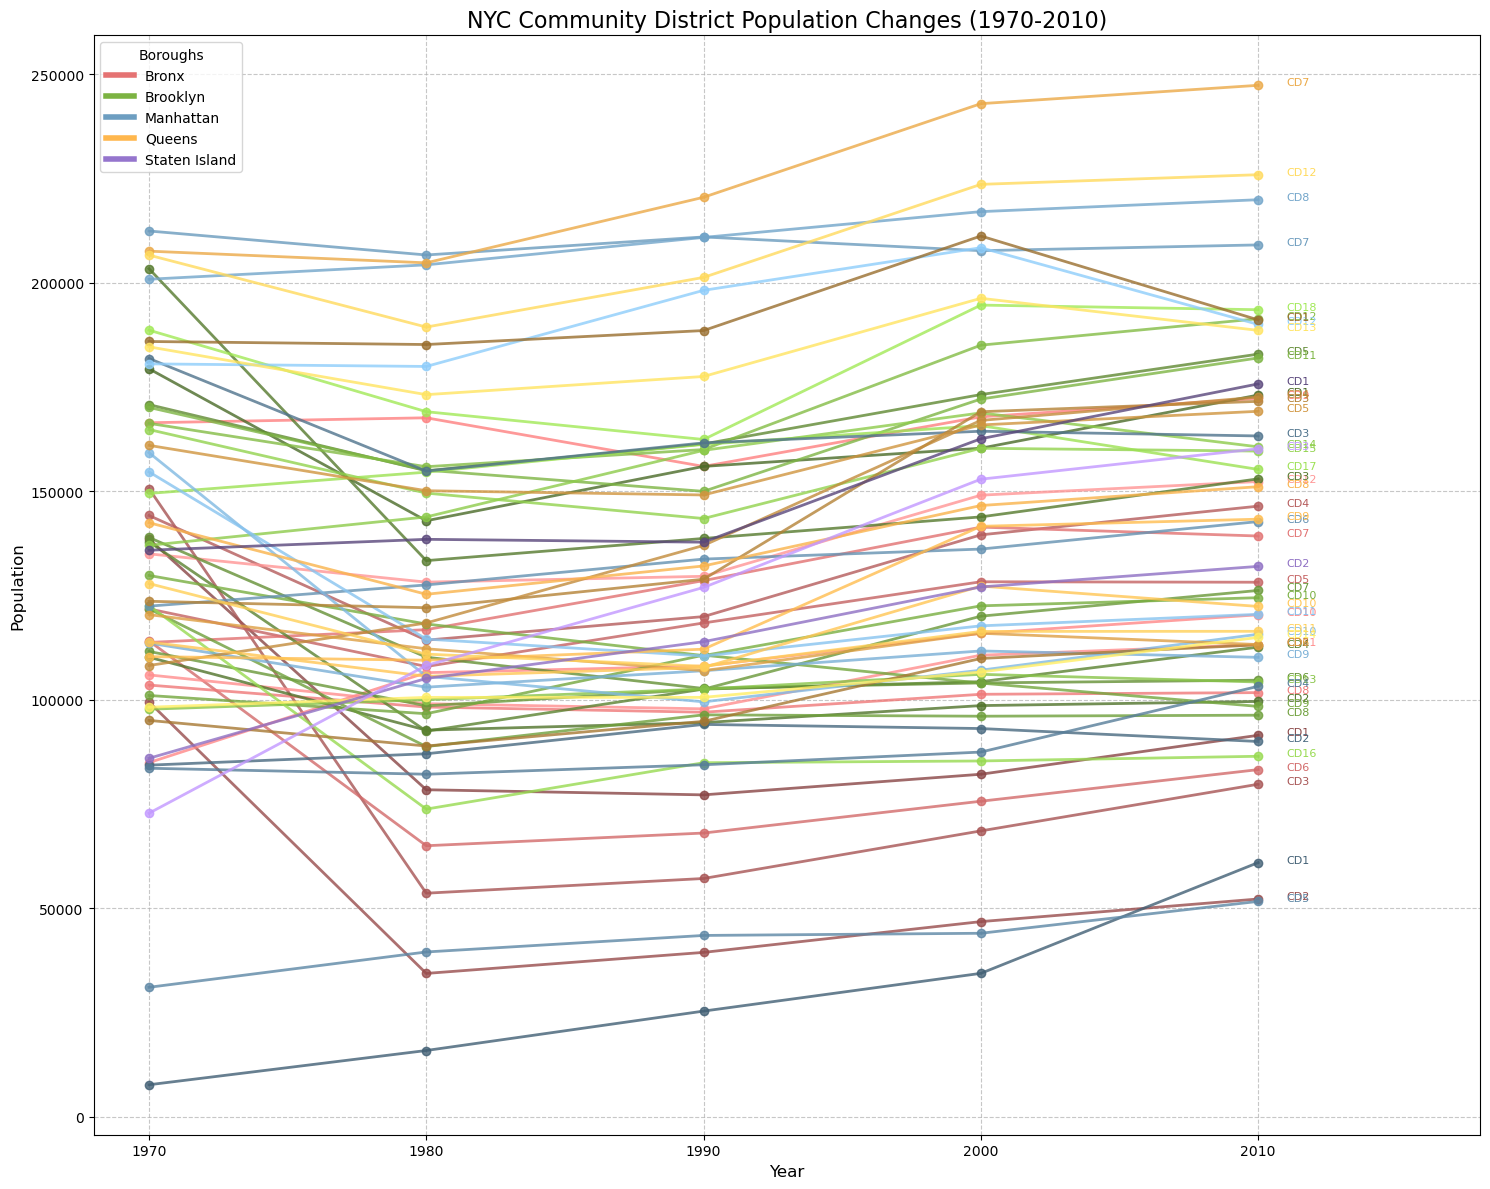

In [39]:
# Years for which we have population data
years = [1970, 1980, 1990, 2000, 2010]


def generate_gradient_colors(base_color, count):
    """Generate a gradient of colors from lighter to darker based on a base color"""
    if count == 1:
        return [base_color]
    
    base_rgb = mcolors.to_rgb(base_color)
    
    # Create a gradient from lighter to darker
    colors = []
    for i in range(count):
        # Adjust factor to control gradient intensity (0.6 to 1.3 range)
        factor = 0.6 + (i / (count - 1)) * 0.7
        r = min(1.0, base_rgb[0] * factor)
        g = min(1.0, base_rgb[1] * factor)
        b = min(1.0, base_rgb[2] * factor)
        colors.append((r, g, b))
    
    return colors

# Step 1: Process the data for plotting
# Get unique boroughs
#pulls out the distinct indices for the boroughs in data
boroughs = df['Borough'].unique()

# Create a figure with a suitable size
plt.figure(figsize=(15, 12))

# Count districts per borough to prepare color gradients
district_counts = df.groupby('Borough').size()

# Generate color gradients for each borough
borough_palettes = {}
for borough in boroughs:
    abbr = borough_map[borough]
    base_color = borough_colors[abbr]
    count = district_counts[borough]
    borough_palettes[borough] = generate_gradient_colors(base_color, count)

# For legend
borough_patches = []
borough_labels = []

# Plot each district's population over time
for borough in boroughs:
    # Get districts for this borough
    borough_df = df[df['Borough'] == borough].copy()
    
    # Sort by CD Number to ensure consistent color assignment
    borough_df = borough_df.sort_values('CD Number')
    
    # Get the color palette for this borough
    palette = borough_palettes[borough]
    
    # Create a patch for the borough legend
    borough_patch = plt.Line2D([0], [0], color=borough_colors[borough_map[borough]], 
                              lw=4, label=borough)
    borough_patches.append(borough_patch)
    borough_labels.append(borough)
    
    # Plot each district
    for i, (_, district) in enumerate(borough_df.iterrows()):
        # Get the color for this district
        color = palette[i]
        
        # Create label with borough, CD number and name
        label = f"{borough} CD{district['CD Number']}: {district['CD Name']}"
        
        # Extract population data for years
        pop_data = [district[f'{year} Population'] for year in years]
        
        # Plot the line
        plt.plot(years, pop_data, marker='o', color=color, linewidth=2, alpha=0.8)
        
        # Add a label at the end of the line
        plt.text(years[-1] + 1, pop_data[-1], 
                f"CD{district['CD Number']}", 
                fontsize=8, color=color)

# Add borough legend
plt.legend(handles=borough_patches, labels=borough_labels, 
           title="Boroughs", loc='upper left', fontsize=10)

# Customize the plot
plt.title('NYC Community District Population Changes (1970-2010)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to show only the years we have data for
plt.xticks(years)

# Add some padding to the right for the labels
plt.xlim(min(years) - 2, max(years) + 8)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

Dataset #3: Locaiton of waste disposal facilities in NYC

This data consists of the locations where waste is segregated and managed by the DSNY. This is also the places where the trucks drop off the waste.

In [42]:
data_dsny_waste_locations=pd.read_csv("datas/Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20241226.csv")

In [5]:
#run this if you want to see the data frame; remove the .head() if you want to see more.
data_dsny_waste_locations.head()

,Name,Unique ID,Type,Street Address,Borough/City,State,Zipcode,Latitude,Longitude,Point
0,91st St Marine Transfer Station (DSNY),181,MTS,1740 York Avenue,Manhattan,NY,10128,40.779299,-73.943137,POINT (-73.9431369838549 40.7792990473106)
1,Bethlehem,294,LF,2335 Applebutter Rd,Bethlehem,PA,18015,40.625325,-75.307146,POINT (-75.3071459639353 40.6253249950004)
2,Keystone,345,LF,249 Dunham Dr,Dunmore,PA,18512,41.422776,-75.605997,POINT (-75.6059970857193 41.4227764252404)
3,Covanta - Hempstead,114,WTE,600 Merchants Concourse,Westbury,NY,11590,40.738175,-73.590597,POINT (-73.5905972370384 40.7381754192889)
4,Seneca Meadows,162,LF,1786 Salcman Rd,Waterloo,NY,13165,42.917090,-76.846185,POINT (-76.8461851760186 42.9170895380449)


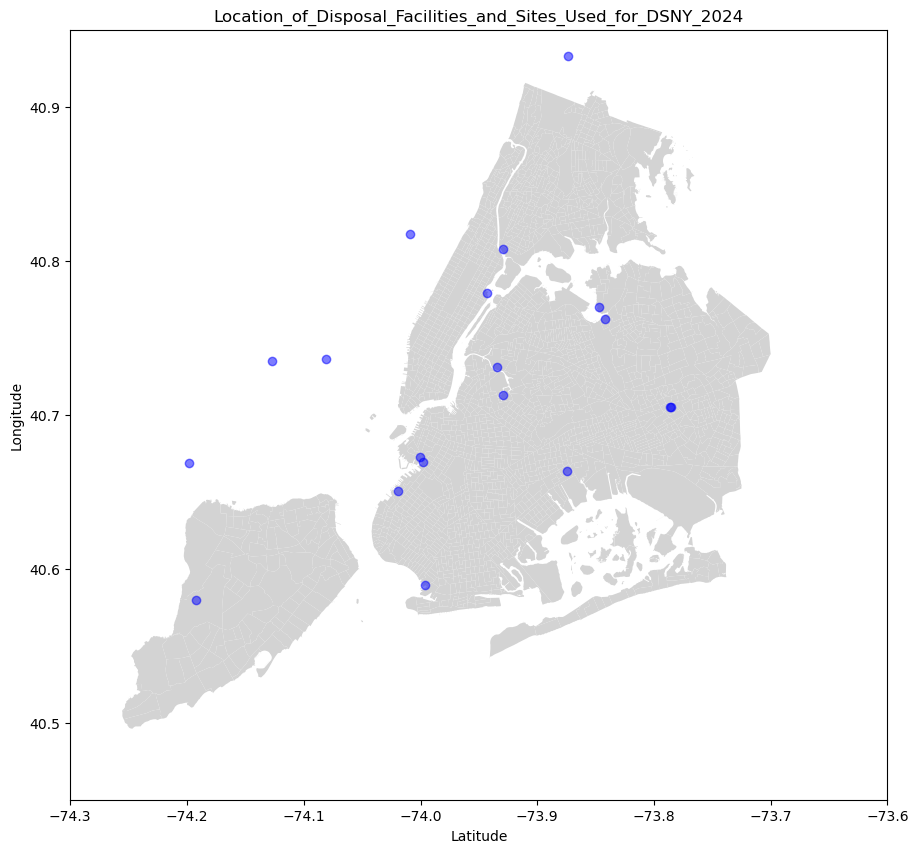

In [46]:
latitudes = data_dsny_waste_locations["Latitude"]
longitudes = data_dsny_waste_locations["Longitude"]

shapefile_path = 'datas/geo_export_d23170a5-e5a3-40ec-b2bc-491a916d11cd.shp'
nyc = gpd.read_file(shapefile_path)


fig, ax = plt.subplots(figsize=(15, 10))
nyc.plot(ax=ax, color='lightgray')
plt.scatter(longitudes,latitudes,marker="o",color="blue",alpha=.51)
plt.xlim([-74.3,-73.6])
plt.ylim([40.45,40.95])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY_2024")
plt.savefig("Location of disposal facilities within NYC", dpi=300, bbox_inches='tight')
plt.show()

From the above analysis we learn that some of the NYC's collected trash is not even managed within the city but infact is transported out to NJ and PA

Dataset #4: the following dataset contains recyling and diversion rates in CDTA's from 2016 up till 2019.

Here are the defitions used by Department of Sanitation NYC

Diversion rate is the percentage of all waste that is diverted away from disposal through recycling, composting, or other beneficial use. The diversion rate applies to the aggregate waste stream and is not applicable to individual materials.

Capture rate measures recyclable materials that are properly recycled in their respective recycling streams as a percentage of the total aggregate of that material across all streams. “Uncaptured material” refers to recyclable materials that are improperly disposed.

"Refuse tons" refers to the weight (in tons) of trash or garbage collected from residential and institutional areas in New York City. This includes recylable and non recylable materials

In [47]:
data_recyling=pd.read_csv("datas/Recycling_Diversion_and_Capture_Rates.csv")

Since 2019 is the most recent detailed data available, we will use that for the analysis. However with monior tweak the coee should be useable for any year's data.

Lets clean and extract the data for 2019. 

In [56]:
#This collects all the data in the df that is for 2019 or above. 
#Once DSNY releases more data, we can run the same code for other years.
df_filtered_recyling = data_recyling[data_recyling['Fiscal Year'] >= 2019]

# Display the filtered DataFrame
df_filtered_recyling.head()


,Zone,District,Fiscal Month Number,Fiscal Year,Month Name,Diversion Rate-Total (Total Recycling / Total Waste),Capture Rate-Paper (Total Paper / Max Paper),Capture Rate-MGP (Total MGP / Max MGP),Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100
0,Brooklyn North,BKN01,10,2019,April,14.7,44.9,43.0,44.1
1,Brooklyn North,BKN02,10,2019,April,20.0,34.2,57.9,41.2
2,Brooklyn North,BKN03,10,2019,April,12.2,33.5,44.9,38.2
3,Brooklyn North,BKN04,10,2019,April,15.5,35.2,68.5,48.8
4,Brooklyn North,BKN05,10,2019,April,10.1,22.3,45.1,31.5


In [58]:
#If you want to look at data for a particular district throughtout year:
#BE CAREFUL ABOUT 0 and O (which is capital letter O. The code uses the number 0.)
df_filtered_BKNO1 = df_filtered_recyling[df_filtered_recyling['District'] == 'BKN01']

Dataset #5: the number of public bins, their type and their location in NYC
Note that this data is old. However, this code can be used to read and extract newed data from pdf.

In [71]:
pdf_file="datas/AllBorough_PSRRMay2016.pdf"

In [74]:
tables = camelot.read_pdf(pdf_file, pages='all', flavor='stream')
df = tables[1].df

Dataset #6: NYC pluto data which is a PDF and csv file about the infrasturucture of the city 

In [75]:
pluto_data=pd.read_csv("datas/pluto_24v4.csv")

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_1064/1911856808.py:1: DtypeWarning: Columns (21,22,24,26,28,65,66,88) have mixed types. Specify dtype option on import or set low_memory=False.
  pluto_data=pd.read_csv("datas/pluto_24v4.csv")


Dataset #7: This is the compiled dataframe that we will use. This contains recyling and waste data from 2019, demographics from NYC pop finder data of 2020 and infrastucture data from PLUTO.

In [68]:
data_demo=pd.read_csv("datas/DemographicsTable.csv")
data_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   District                                      59 non-null     object 
 1   Organic Tons                                  59 non-null     float64
 2   MGP tons                                      59 non-null     float64
 3   Paper Tons                                    59 non-null     float64
 4   Refuse Tons                                   59 non-null     float64
 5   Diversion rate (%)                            59 non-null     float64
 6   Total Population                              59 non-null     int64  
 7   Median Age                                    59 non-null     float64
 8   Population/acre                               59 non-null     float64
 9   Hispanic                                      59 non-null     float

Correlation matrix is a basic way to recognize what features show correlated behaviours. This can help in exploratory data analysis between the features and can help in reconging the features you want for your model/algortihm. For example, we can visually pull out that Diversion rate is correlated with white non-hispanic population percentage and median/mean household income. We also see interesting features like Refuse tons (which is all the garbage collected) is inversely proportional with the population density of the CDTA.

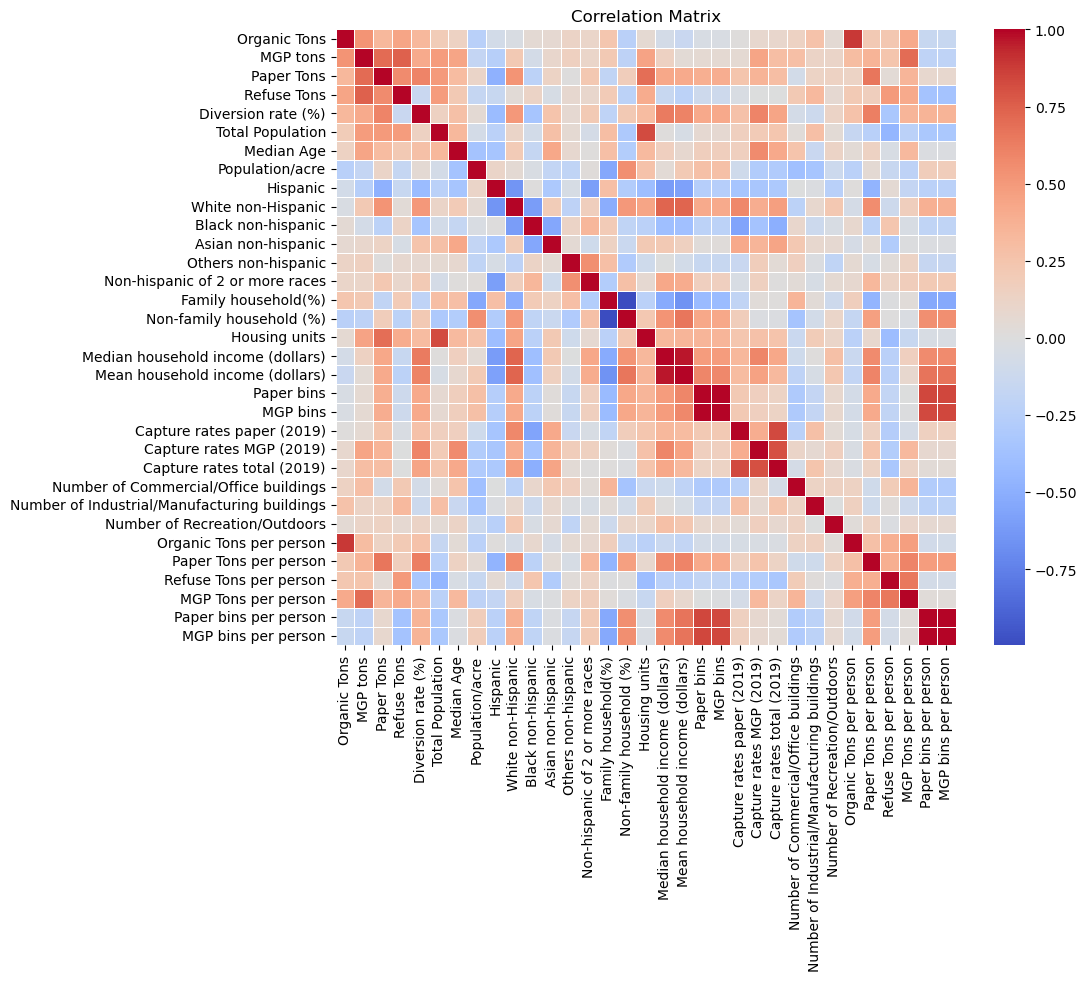

In [79]:
numeric_data = data_demo.select_dtypes(include='number')  # Select only numeric columns
corr_matrix = numeric_data.corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()